# Dumaguete OrNV Isolate - Bioassay 1

## Introduction
This notebook documents an initial bioassay of the Dumaguete isolate of *Oryctes* nudivirus. 

## Materials and Methods

### Virus Sample
This virus was isolated from a single infected *Oryctes rhinoceros* Guam biotype specimen collected near Dumaguete, Negros Island, Philippines in January 2017. 

### Test Insects
Test insects were collected weekly from 31 coconut rhinoceros beetle pheromone traps (barrel traps) at the University of Guam Agricultural Experiment Station at Yigo. Beetles were held individually in numbered Mason jars partially filled with moist peat moss which were stored in an environmental cabinet at a temperature of 80 degrees F. Each was fed a slice of banana weekly.  Beetles were reared an average of 46 days (range: 23 d to 75 d) prior to treatment. 

### Treatment
* 20 beetles were selected at random for treatment and another 20 were selected for experimental control
* 100 mg of sucrose was disolved in a 1 ml sample of the virus. Each beetle was given a 40 microlitre dose of this solution by pipetting a drop onto its mouthparts. A placebo was not given to beetles in the experimental control group.
* All beetles were provided a slice of banana on the day following treatment.

### Observation procedure
* Beetles were observed weekly.
* Each beetle was weighed and its mass was entered immediately into a spreadsheet. 
* A slice of banana was added immediately after each beetle was returned to its jar.

### Analysis
* The data model includes 2 tables saved as Excel spreadsheets (see below).
* An empty **mass** field in the **observations** table indicates that the beetle died prior to observation.

## Results and Discussion
* The beetles did not readily drink the 40 microlitre dose applied to their mouthparts. A food incorporation bioassay may be more efficient.
* During the 28 day bioassay period, 1 of 20 virus treated beetles died and 4 of 20 beetles in the experimental control group died. The difference in mortality is not significant (p = 0.34; Fisher's exact test).  Post mortems indicated that all of the dead beetles were infected with *Metarhizium majus*. Guts looked normal.
* There was a significant difference in weight loss during the first week of the bioassay (p = 0.02; Welch's t-test). However, there was no significant difference in weight loss during succeding weeks. Difference in weight loss during the first week may be due to the fact that the virus treated beetles were handled much more than the contol group. 
* In conclusion, results from this initial bioassay does not indicate pathogenicity to CRB-G for the OrNV Dumaguete isolate.

## Calculations

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from scipy.stats import ttest_ind, fisher_exact

%matplotlib inline  
pd.options.display.max_rows = 4

### import data from spreadsheet

In [23]:
DATAFILE = 'aubrey.xlsx'

df_jars = pd.read_excel(DATAFILE, 'jars')
df_jars

,jar_number,date_collected,sex,treatment
0,32,2017-10-02,Female,virus
1,85,2017-10-02,Female,virus
...,...,...,...,...
38,1263,2017-10-18,Male,control
39,1633,2017-10-23,Male,control


In [24]:
df_observations = pd.read_excel(DATAFILE, 'observations')
df_observations

,jar_number,observation_date,mass,note
0,32,2017-11-15,4487.0,NaN
1,50,2017-11-15,4136.0,mites
...,...,...,...,...
198,1263,2017-12-13,3036.0,NaN
199,1633,2017-12-13,3399.0,NaN


In [25]:
# Create a dict containing pairs of dates.
# The index is an observation date and the value is the previous observation date

obs_dates = df_observations.observation_date.unique()
prev_obs_date = dict(zip(obs_dates[1:], obs_dates))

# Example usage:
# y = df_observations.observation_date[100]
# print y
# prev_obs_date[y.to_datetime64()]

In [26]:
# Add a new column "days_post_treatment" to "df_observations" and populate it

treatment_date = df_observations.observation_date.min().to_datetime64() # Assumes all beetles treated on same date
df_observations['days_post_treatment'] = np.nan

for index, row in df_observations.iterrows():
    try:
        date = row.observation_date.to_datetime64()
        if date == treatment_date:
            days_post_treatment = 0
        else:
            days_post_treatment = date - treatment_date
            # Convert from timedelta in nanoseconds to integer days
            days_post_treatment = (days_post_treatment / np.timedelta64(1, 'D')).astype(int)
    except:
        continue
    df_observations.loc[index, 'days_post_treatment'] = days_post_treatment

# Add a new column "mass_change" to "df_observations" and populate it

df_observations['mass_change'] = np.nan

for index, row in df_observations.iterrows():
    try:
        date = row.observation_date.to_datetime64()
        prev_date = prev_obs_date[date]
        prev_mass = int(df_observations.loc[(df_observations.observation_date==prev_date) & 
            (df_observations.jar_number==row.jar_number), 'mass'])
        mass_change = int(row.mass) - prev_mass        
    except:
        continue
    df_observations.loc[index, 'mass_change'] = mass_change

df_observations

,jar_number,observation_date,mass,note,days_post_treatment,mass_change
0,32,2017-11-15,4487.0,NaN,0.0,NaN
1,50,2017-11-15,4136.0,mites,0.0,NaN
...,...,...,...,...,...,...
198,1263,2017-12-13,3036.0,NaN,28.0,258.0
199,1633,2017-12-13,3399.0,NaN,28.0,-194.0


In [27]:
df = df_observations.merge(df_jars, on='jar_number')
df

,jar_number,observation_date,mass,note,days_post_treatment,mass_change,date_collected,sex,treatment
0,32,2017-11-15,4487.0,NaN,0.0,NaN,2017-10-02,Female,virus
1,32,2017-11-22,3900.0,NaN,7.0,-587.0,2017-10-02,Female,virus
...,...,...,...,...,...,...,...,...,...
198,1633,2017-12-06,3593.0,NaN,21.0,447.0,2017-10-23,Male,control
199,1633,2017-12-13,3399.0,NaN,28.0,-194.0,2017-10-23,Male,control


observation 	control 		virus
date 		mean mass change (mg) 	mean mass change (mg) 	p-value
2017-11-22	-163 (n=20)		-298 (n=20)		0.0195
2017-11-29	-107 (n=19)		-70 (n=20)		0.3216
2017-12-06	3 (n=18)		-40 (n=20)		0.4429
2017-12-13	-41 (n=16)		-37 (n=19)		0.9350


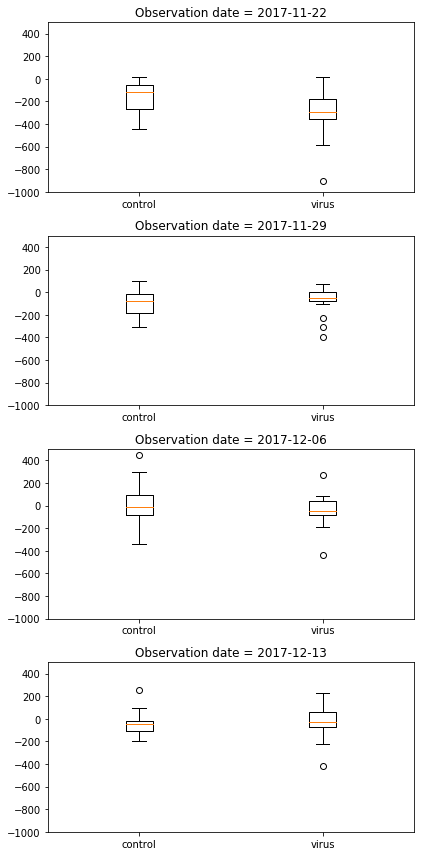

In [28]:
fig = plt.figure(figsize=(6, 12))
i = 0
print 'observation \tcontrol \t\tvirus'
print 'date \t\tmean mass change (mg) \tmean mass change (mg) \tp-value'
for date in prev_obs_date.keys():
    i += 1
    v = df.loc[(df.observation_date==date) & 
                            (df.treatment=='virus'), 'mass_change']
    v = v[-np.isnan(v)]
    c = df.loc[(df.observation_date==date) & 
                            (df.treatment=='control'), 'mass_change']
    c = c[-np.isnan(c)]
    
    statistic, pvalue = ttest_ind(c, v, nan_policy='omit', equal_var=False)
    print '{}\t{:.0f} (n={})\t\t{:.0f} (n={})\t\t{:.4f}'.format(
        str(date)[:10], np.mean(c), len(c), np.mean(v), len(v), pvalue)
    ax = fig.add_subplot(4,1,i)
    title = 'Observation date = ' + str(date)[:10]
    ax.set_title(title)
    ax.boxplot([c.values, v.values])
    ax.set_xticklabels(['control', 'virus'])
    ax.set_ylim([-1000, 500])
plt.tight_layout()

### Mortality

In [29]:
df_groupby = df.groupby(['days_post_treatment','treatment'])['mass'].count().unstack()
df_groupby

treatment,control,virus
days_post_treatment,,
0.0,20,20
7.0,20,20
...,...,...
21.0,18,20
28.0,16,19


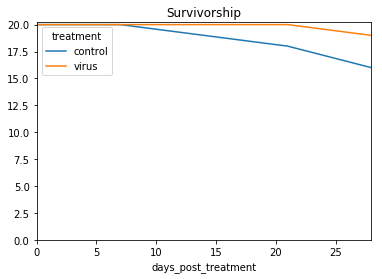

In [34]:
myplot = df_groupby.plot()
ylim = myplot.axes.get_ylim()
myplot.axes.set_ylim(0, ylim[1])
myplot.set_title('Survivorship');

In [31]:
c_total = df_groupby.control.max()
c_alive = df_groupby.control.min()
c_dead = c_total - c_alive
v_total = df_groupby.virus.max()
v_alive = df_groupby.virus.min()
v_dead = v_total - v_alive
print '{}\t{}\t{}'.format('', 'alive', 'dead')
print '{}\t{}\t{}'.format('control', c_alive, c_dead)
print '{}\t{}\t{}'.format('virus', v_alive, v_dead)
print
oddsratio, pvalue = fisher_exact([[c_alive, c_dead], [v_alive, v_dead]])
print 'Fisher''s exact test p-value = {}'.format(pvalue)

	alive	dead
control	16	4
virus	19	1

Fishers exact test p-value = 0.341649341649


### Holding time prior to treatment

In [32]:
# Calculate days held prior to treatment

pd.options.display.max_rows=100
df_temp = df[df.observation_date==treatment_date]
(df_temp.observation_date - df_temp.date_collected).describe()

count                         40
mean            46 days 15:00:00
std      18 days 08:07:05.397423
min             23 days 00:00:00
25%             33 days 00:00:00
50%             44 days 00:00:00
75%             57 days 00:00:00
max             75 days 00:00:00
dtype: object